# Fits

## Pakete einlesen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import linregress
from PhyPraKit.phyFit import hFit
import inspect

## $\text{\LaTeX}$ -Konfiguration

So werden alle Texte in den Plots getext

In [3]:
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{fourier}\usepackage{siunitx}'
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.size'] = 12


## Daten einlesen

In [4]:
data_CoFull = np.loadtxt("Daten/SpectrumFull.txt")
channel_CoFull = data_CoFull[:,0]
counts_CoFull = data_CoFull[:,1]
df_CoFull = pd.DataFrame({"Counts": counts_CoFull}, index=channel_CoFull.astype(int))

data_CoCut = np.loadtxt("Daten/Spectrum_cut14keV.txt")
channel_CoCut = data_CoCut[:,0]
counts_CoCut = data_CoCut[:,1]
df_CoCut = pd.DataFrame({"Counts": counts_CoCut}, index=channel_CoCut.astype(int))

data_velocity = np.loadtxt("Daten/velocity-calibration.txt")
keineAhnung_velocity = data_velocity[0][1] # TODO: herausfinden, was das ist...
time_velocity = data_velocity[0][1] * 1e-5
channel_velocity = data_velocity[:,0][2:]
counts_velocity = data_velocity[:,1][2:]
sig_counts_velocity = np.sqrt(counts_velocity) # nochmal gucken, ob das stimmt
df_velocity = pd.DataFrame({"Counts": counts_velocity}, index=channel_velocity.astype(int))

## Co Spektrum und Energieintervall

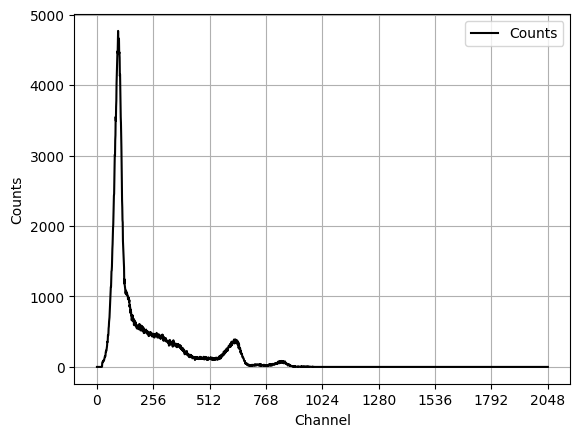

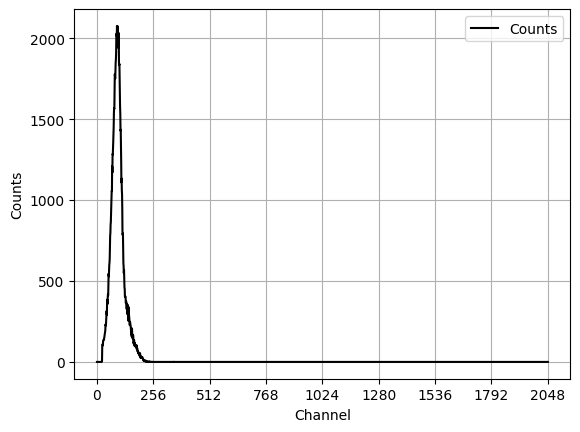

In [9]:
i = 0
for df in [df_CoFull, df_CoCut]:
    df.plot(y=["Counts"], label=["Counts"], lw=1.5, color='black')
    plt.xlabel("Channel")
    plt.ylabel("Counts")
    plt.xticks([0, 256, 512, 768, 1024, 1280, 1536, 1792, 2048])
    plt.grid()
    plt.savefig(f"Results/Co{i}.pdf")
    i += 1


## Linearer Fit der Geschwindigkeit

Fehler auf Counts:
$$\sigma_{Counts} = \sqrt{Counts}$$
Fehler auf Frequenz (Gauß):
$$\sigma_{Frequency} = \frac{\sigma_{Counts}}{time}$$

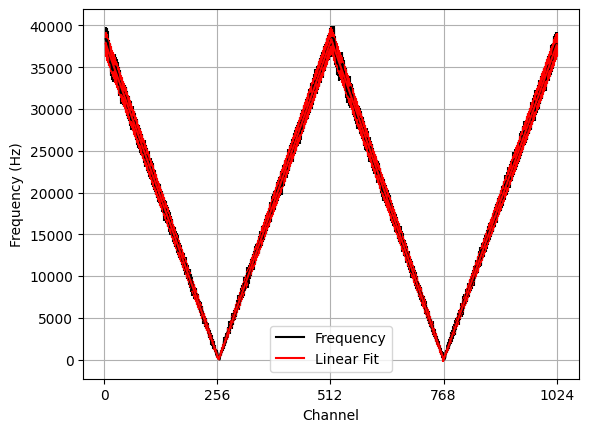

In [30]:
# Find Peaks in Signal:
peak, _ = find_peaks(df_velocity["Counts"], distance=500)
dips, _ = find_peaks(-df_velocity["Counts"], distance=500)
peaks = np.sort(np.concatenate((peak, dips)))
peaks[0] = 0
peaks = np.append(peaks, df_velocity.index[-1])


# Signal wird in verschiedene Regionen eingeteilt.
# Die Regionen sind durch die Peaks begrenzt.
df_velocity["Region"] = 0

for i, row in df_velocity.iterrows():
    for p in range(len(peaks) - 1):
        if peaks[p] < i <= peaks[p + 1]:
            df_velocity.loc[i, "Region"] = p + 1


# Calculate frequency from data:
df_velocity["Frequency"] = df_velocity["Counts"]/time_velocity
df_velocity["sigma_Frequency"] = np.sqrt(df_velocity["Counts"])/time_velocity

# Linear fit for each region:
res = []
for i in range(len(peaks) - 1):
    x = df_velocity.loc[df_velocity["Region"] == i + 1].index
    y = df_velocity.loc[df_velocity["Region"] == i + 1]["Frequency"]
    res += [linregress(x, y)]
    y_fit = res[i].intercept + res[i].slope*x
    # Ergebnis des Fits in DataFrame speichern
    df_velocity.loc[df_velocity["Region"] == i + 1, "Frequency_fitted"] = y_fit
    # Gemessen wurde nur der Betrag der Geschwindigkeit, hier das Vorzeichen für jede Region
    vz = [1, -1, -1, 1]
    df_velocity.loc[df_velocity["Region"] == i + 1, "velocity [mm/s]"] = vz[i] * 325 * y_fit *1e-6 # letzter Faktor: 1e-6, weil time_velocity in µs sein soll

# Fit angucken, um zu schauen, ob es funktioniert hat.
df_velocity.plot(y=["Frequency", "Frequency_fitted"], yerr="sigma_Frequency", label=["Frequency", "Linear Fit"], lw=1.5, color=["black", "red"])
plt.xlabel("Channel")
plt.ylabel("Frequency (Hz)")
plt.xticks([0, 256, 512, 768, 1024])
plt.grid()
plt.savefig('Results/VelocityCalibration_fit.pdf')

v = df_velocity["velocity [mm/s]"]


## Geschwindigkeit anzeigen

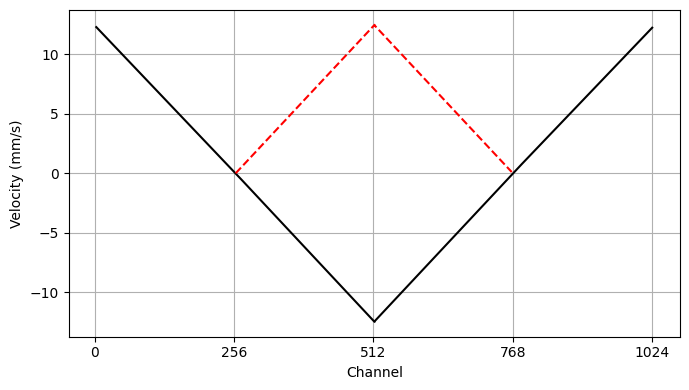

In [31]:
plt.figure(figsize=(7, 4))
plt.plot(v.index, v, color='black')
plt.plot(df_velocity[(df_velocity["Region"] == 2) + (df_velocity["Region"] == 3)].index, 325 * df_velocity[(df_velocity["Region"] == 2) + (df_velocity["Region"] == 3)]["Frequency_fitted"] * 1e-6, "--", color='red')
plt.xlabel("Channel")
plt.ylabel("Velocity (mm/s)")
plt.xticks([0, 256, 512, 768, 1024])
plt.grid()
plt.tight_layout()
plt.savefig("Results/velocity-calibration.pdf")

## Noch mehr Daten einlesen

In [32]:
data_FeNatural = np.loadtxt("Daten/FeNatural.txt")
keineAhnung_FeNatural = data_FeNatural[0][1] # TODO: herausfinden, was das ist...
time_FeNatural = data_FeNatural[0][1] * 1e-5
channel_FeNatural = data_FeNatural[:,0][2:]
counts_FeNatural = data_FeNatural[:,1][2:]
sig_counts_FeNatural = np.sqrt(counts_FeNatural)
df_FeNatural = pd.DataFrame({"Counts": counts_FeNatural}, index=channel_FeNatural.astype(int))

data_FePO4 = np.loadtxt("Daten/FePO4.txt")
keineAhnung_FePO4 = data_FePO4[0][1] # TODO: herausfinden, was das ist...
time_FePO4 = data_FePO4[0][1] * 1e-5
channel_FePO4 = data_FePO4[:,0][2:]
counts_FePO4 = data_FePO4[:,1][2:]
sig_counts_FePO4 = np.sqrt(counts_FePO4)
df_FePO4 = pd.DataFrame({"Counts": counts_FePO4}, index=channel_FePO4.astype(int))

data_FeSO4 = np.loadtxt("Daten/FeSO4.txt")
keineAhnung_FeSO4 = data_FeSO4[0][1] # TODO: herausfinden, was das ist...
time_FeSO4 = data_FeSO4[0][1] * 1e-5
channel_FeSO4 = data_FeSO4[:,0][2:]
counts_FeSO4 = data_FeSO4[:,1][2:]
sig_counts_FeSO4 = np.sqrt(counts_FeSO4)
df_FeSO4 = pd.DataFrame({"Counts": counts_FeSO4}, index=channel_FeSO4.astype(int))

data_stainlessSteel = np.loadtxt("Daten/stainless-steel.txt")
keineAhnung_stainlessSteel = data_stainlessSteel[0][1] # TODO: herausfinden, was das ist...
time_stainlessSteel = data_stainlessSteel[0][1] * 1e-5
channel_stainlessSteel = data_stainlessSteel[:,0][2:]
counts_stainlessSteel = data_stainlessSteel[:,1][2:]
sig_counts_stainlessSteel = np.sqrt(counts_stainlessSteel)
df_stainlessSteel = pd.DataFrame({"Counts": counts_stainlessSteel}, index=channel_stainlessSteel.astype(int))

df_iter = [
    df_FeNatural,
    df_FePO4,
    df_FeSO4,
    df_stainlessSteel
]

# Geschwindigkeit als neuen Index für Dataframes

for df in df_iter:
    df["velocity [mm/s]"] = v
    df.set_index("velocity [mm/s]", inplace=True)

## Fitting

### Modellfunktionen

In [33]:
def lorentzian(ch, ch0, gamma, A):
    """
    Einzelner Lorentzian Peak.

    Args:
        ch: Kanalnummer bzw. Geschwindigkeit
        ch0: Mittelpunkt des Peaks
        gamma: full width at half maximum
        A: Skalierungsfaktor; positiv, wenn Peak nach unten zeigt

    Returns:
        Den Peak natürlich...
    """
    return -A / (1 + ((ch - ch0) / (gamma/2) )**2)

# Individuelle Modelle, weil ich zu faul war, mir was Besseres zu überlegen.
# Summe aus mehreren Peaks plus konstanter Untergrund f

def model_FeNatural(ch, f, p1, g1, A1, p2, g2, A2, p3, g3, A3, p4, g4, A4, p5, g5, A5, p6, g6, A6):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + lorentzian(ch, p3, g3, A3) + lorentzian(ch, p4, g4, A4) + lorentzian(ch, p5, g5, A5) + lorentzian(ch, p6, g6, A6) + f

def model_FePO4(ch, f, p1, g1, A1, p2, g2, A2):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + f

def model_FeSO4(ch, f, p1, g1, A1, p2, g2, A2):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + f

def model_stainlessSteel(ch, f, p1, g1, A1):
    return lorentzian(ch, p1, g1, A1) + f

### Übelste Kacke, die einfach nicht dokumentiert ist

In [66]:
# Objekt, um über DataFrames und Modelle iterieren zu können.
# Die letzte Zahl gibt die Anzahl der zu suchenden Peaks an.
fit_iter = [
    #("Vacromium", df_stainlessSteel, model_stainlessSteel, 1),
    #("FePO4", df_FePO4, model_FePO4, 2),
    #("FeSO4", df_FeSO4, model_FeSO4, 2),
    ("Natural Iron", df_FeNatural, model_FeNatural, 6)
]

for name, df, model, ps in fit_iter:
    print(name)
    # Dataframe nach Geschwindigkeiten sortieren.
    df.sort_index(inplace=True)
    x = df.index.values # Geschwindigkeit
    bin_width = np.mean([x[i+1] - x[i] for i in range(len(x)-1)])/2 # Breite der Bins
    bin_edges = np.arange(x[0]-bin_width/2, x[-1]+bin_width/2, bin_width)
    y = df["Counts"].values # Counts
    # Alle Peaks in Signal finden, um gute Startwerte für den Fit zu erhalten:
    peaks = find_peaks(-y, distance=30)[0]
    print(f"found {len(peaks)} peaks")
    # Die Peaks der Höhe nach sortieren und nur die obersten ps Peaks behalten
    peaks = peaks[y[peaks].argsort()[:ps]]
    print(f"chose {len(peaks)} highest peaks")
    # Startparameter und Grenzen für den Fit definieren
    y_mean = np.mean(y)
    y_std = np.std(y) # Erwartete Höhe des Untergrunds
    p0 = [y_mean]
    bounds = [
        [y_mean - y_std],
        [y_mean + y_std]
    ]
    for p in peaks:
        p0 += [x[p], 0.5, 500]
        bounds[0] += [x[p] - 1, -np.inf, -np.inf]
        bounds[1] += [x[p] + 1, np.inf, np.inf]
    constraints = np.transpose([list(range(len(bounds[0]))), bounds[0], bounds[1]])
    print(p0, constraints)
    # Fit durchführen
    pval, perr, pcov, gof = hFit(
        fitf=model,
        bin_contents=y,
        bin_edges=bin_edges,
        p0=p0,
        constraints=constraints,
        plot=True,
        plot_cor=False,
        showplots=False,
        plot_band=True,
        quiet=True,
        axis_labels=["Velocity (mm/s)", "Counts"],
        data_legend="Data",
        model_legend="Fit",
        return_fitObject=False
    )
    # Ergebnisse ausgeben
    print(f"Fit results for {name}:")

Natural Iron
found 25 peaks
chose 6 highest peaks
[6150.213307240704, 5.490455756094196, 0.5, 500, -3.3853785986468403, 0.5, 500, 3.1953135854207, 0.5, 500, -5.677867980949937, 0.5, 500, -1.0879578093484314, 0.5, 500, 0.7567250290801147, 0.5, 500] [[ 0.00000000e+00  6.02498616e+03  6.27544046e+03]
 [ 1.00000000e+00  4.49045576e+00  6.49045576e+00]
 [ 2.00000000e+00            -inf             inf]
 [ 3.00000000e+00            -inf             inf]
 [ 4.00000000e+00 -4.38537860e+00 -2.38537860e+00]
 [ 5.00000000e+00            -inf             inf]
 [ 6.00000000e+00            -inf             inf]
 [ 7.00000000e+00  2.19531359e+00  4.19531359e+00]
 [ 8.00000000e+00            -inf             inf]
 [ 9.00000000e+00            -inf             inf]
 [ 1.00000000e+01 -6.67786798e+00 -4.67786798e+00]
 [ 1.10000000e+01            -inf             inf]
 [ 1.20000000e+01            -inf             inf]
 [ 1.30000000e+01 -2.08795781e+00 -8.79578093e-02]
 [ 1.40000000e+01            -inf     

RuntimeError: starting value(s) are required

### Tatsächlicher Fit (alte Version mit curve_fit)

In [58]:
# Objekt, um über DataFrames und Modelle iterieren zu können.
# Die letzte Zahl gibt die Anzahl der zu suchenden Peaks an.
fit_iter = [
    ("Vacromium", df_stainlessSteel, model_stainlessSteel),
    ("FePO4", df_FePO4, model_FePO4),
    ("FeSO4", df_FeSO4, model_FeSO4),
    ("Natural Iron", df_FeNatural, model_FeNatural)
]

for name, df, model in fit_iter:
    arg_names = inspect.getfullargspec(model).args
    par_names = arg_names[1:] # Parameter des Modells
    ps = int((len(par_names) - 1)/3) # Anzahl der Peaks
    print(name)
    # Dataframe nach Geschwindigkeiten sortieren.
    df.sort_index(inplace=True)
    x = df.index.values # Geschwindigkeit
    y = df["Counts"].values # Counts
    y_err = np.sqrt(y) # Fehler auf Counts
    # Alle Peaks in Signal finden, um gute Startwerte für den Fit zu erhalten:
    peaks = find_peaks(-y, distance=30)[0]
    print(f"found {len(peaks)} peaks")
    # Die Peaks der Höhe nach sortieren und nur die obersten ps Peaks behalten
    peaks = peaks[y[peaks].argsort()[:ps]]
    print(f"chose {len(peaks)} highest peaks")

    # Startparameter und Grenzen für den Fit definieren
    y_mean = np.mean(y)
    y_std = np.std(y) # Erwartete Höhe des Untergrunds
    p0 = [y_mean]
    bounds = [
        [y_mean - y_std],
        [y_mean + y_std]
    ]
    for p in peaks:
        p0 += [x[p], 0.5, 500]
        bounds[0] += [x[p] - 1, -np.inf, -np.inf]
        bounds[1] += [x[p] + 1, np.inf, np.inf]

    # Fit durchführen
    popt, pcov, infodict, mesg, ier = curve_fit(# So ist eigentlich keine sinnvolle Fehlerrechnung möglich, eventuell nochmal mit kafe oder phyfit probieren
        f=model,
        xdata=x,
        ydata=y,
        p0=p0,
        sigma=y_err,
        absolute_sigma=True,
        bounds=bounds,
        full_output=True
    )
    perr = np.sqrt(np.diag(pcov))

    # Ergebnisse ausgeben
    print(f"Fit results:")
    print(f"{'Peak':<5} {'Position':<20} {'Breite':<20}")
    for i in range(ps):
        print(f"{i+1:<5} {popt[3*i+1]:<7.3f} +/- {perr[3*i+1]:<8.3f} {popt[3*i+2]:<7.3f} +/- {perr[3*i+2]:<8.3f}")

    # Fit-Parameter in DataFrame schreiben
    df["Fit"] = model(x, *popt)
    df["Fit_err"] = model(x, *popt) - model(x, *(popt + perr))
    df["Fit_err"] = df["Fit_err"].abs()

    # Fit-Parameter in Datei schreiben
    with open(f"Daten/fit/{name.replace(' ', '_')}_params.txt", "w") as f:
        f.write("Parameter\tValue\tError\n")
        for i in range(len(popt)):
            f.write(f"{par_names[i]}\t{popt[i]}\t{perr[i]}\n")

    # Gefittete Daten in Datei schreiben
    df.to_csv(f"Daten/fit/{name.replace(' ', '_')}_data.tsv", sep="\t")

    # Ergebnis des Fits graphisch überprüfen
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, label="Data", zorder=5)
    plt.plot(x, model(x, *popt), label="Fit", zorder=15)
    plt.fill_between(x, df["Fit"] + df["Fit_err"], df["Fit"] - df["Fit_err"], alpha=0.5, ls="--", label="Fit error", color="tab:red", zorder=10) # ob das wohl stimmt...
    plt.legend()
    plt.grid()
    plt.ylabel("Counts")
    plt.xlabel("Velocity [mm/s]")
    plt.plot(x[peaks], y[peaks], "x", label="Peaks", color="tab:green")
    for p in range(ps):
        plt.text(x[peaks[p]]+0.5, y[peaks[p]], f"{p + 1}", horizontalalignment="center", verticalalignment="bottom", color="tab:green")
    plt.tight_layout()
    plt.savefig(f"{name}_peaks.pdf")
    plt.legend()
    plt.title(name)
    plt.show()

Vacromium
found 26 peaks
chose 1 highest peaks
Fit results:
Peak  Position             Breite              
1     -0.165  +/- 0.006    0.405   +/- 0.018   


FileNotFoundError: [Errno 2] No such file or directory: 'Daten/fit/Vacromium_params.txt'